<Body>   
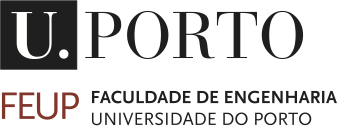   
<h1> <b>Perception and Mapping </b> </h1>
<p><b>Andry Maykol Pinto </b> (amgp@fe.up.pt)</p>
<p><b>Anibal C. Matos </b> (amgp@fe.up.pt)</p>
<p>Department of Electrical and Computer Engineering</p>
</Body>  
FEUP

---

# **Complete:**

 <font color='red'> Christian Geyer </font>

G03

# Underwater inspection of 3D objects using stereo vision

In this assignment, you will explore multiview geometry and 3D reconstruction using data acquired from a calibrated stereo camera rig operating underwater. The stereo rig captures synchronized left and right images of a horizontally placed anode as the sensor moves from left to right along the object.

The underwater environment adds challenges such as light scattering, refraction and contrast loss, which make stereo correspondence and 3D reconstruction more difficult than in air. Your goal is to process this dataset to generate a textured 3D model of the anode, analyze its geometric and physical properties, and evaluate reconstruction quality under different strategies.

The goal is to automatize an inspection pipeline completely. You will build a pipeline that includes:

1) Extracting 3D point clouds from stereo pairs. Texturing the point cloud for visual realism.

2) Applying feature-based or dense stereo matching to estimate disparities.

3) Preprocessing and filtering noisy or spurious 3D points.

4) Registering multiple point clouds into a single coherent 3D model.

5) Performing physical measurements (width, height, volume and bracket dimensions).




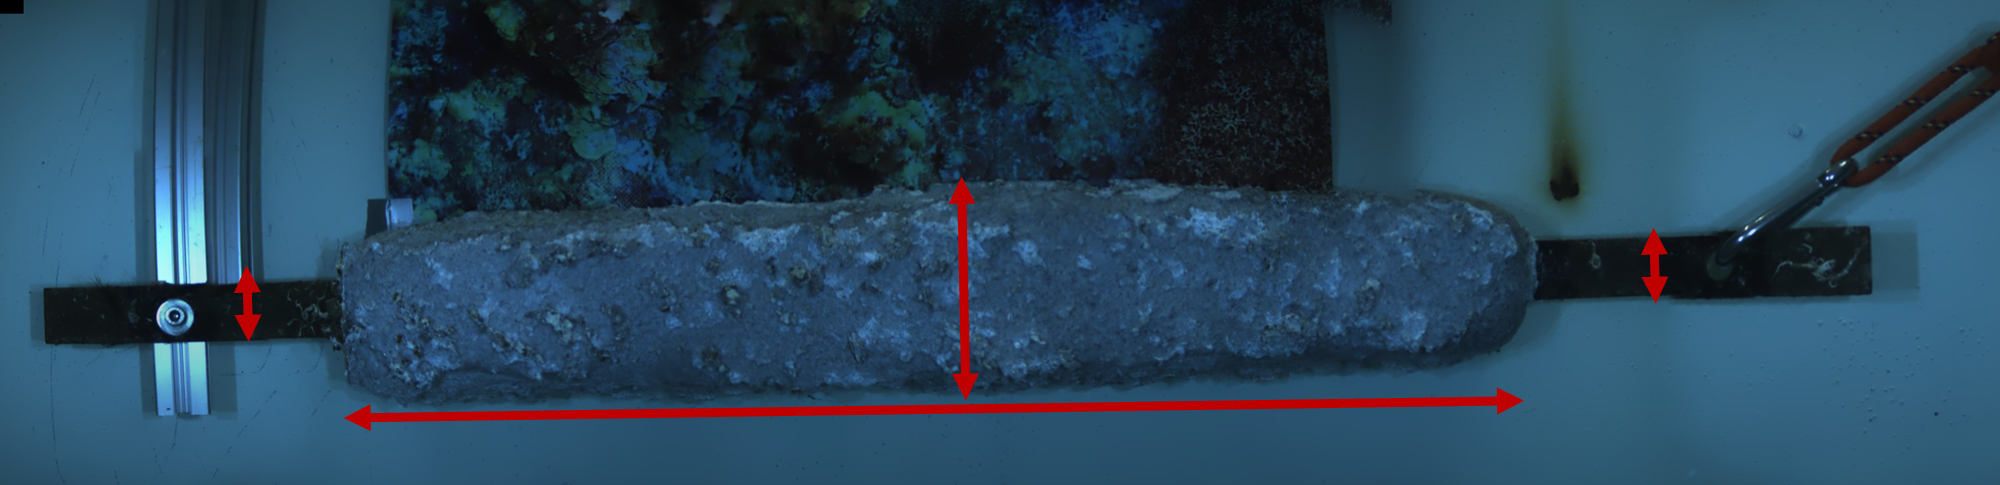

## Prepare Libraries

In [2]:
# Install Open3D library
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 120.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.6 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [3]:
# Import libraries
import numpy as np
import open3d as o3d
import copy

# Visualization
import plotly.graph_objects as go  # plotly to visualize since COLAB does not allow to use O3D functions
import matplotlib.pyplot as plt    # or, Matplotlib
from mpl_toolkits import mplot3d
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

import pickle
import os
from typing import Any, List, Tuple, Dict, Optional


In [4]:
# Visualize point cloud as a scatter plot using matplotlib (as an image!)
def plot_pointcloud_matplotlib_singleview (pt, title_ = ' ', view_ =(-90, 90, 0)):
  colors = None
  if pt.has_colors():
      colors = np.asarray(pt.colors)
  elif pt.has_normals():
      colors = (0.5, 0.5, 0.5) + np.asarray(pt.normals) * 0.5
  else:
      pt.paint_uniform_color((1.0, 0.0, 0.0))
      colors = np.asarray(pt.colors)

  points = np.asarray(pt.points)
  # Single View
  ax = plt.axes(projection='3d')
  ax.view_init(view_[0], view_[1], view_[2])
  ax.axis("on")
  ax.scatter(points[:,0], points[:,1], points[:,2], c=colors)
  ax.set_xlabel('X axis')
  ax.set_ylabel('Y axis')
  ax.set_zlabel('Z axis')

  plt.title(title_)
  plt.show()

#Plotly
def draw_geometries(geometries):
    graph_objects = []

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()

        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
                geometry.colors = o3d.utility.Vector3dVector(colors)
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=2, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

        if geometry_type == o3d.geometry.Geometry.Type.VoxelGrid:
            bounds     = geometry.get_max_bound()-geometry.get_min_bound()

            voxels     = geometry.get_voxels()   # Returns List of Voxel
            vox_mesh   = o3d.geometry.TriangleMesh()

            for v in voxels:
                cube = o3d.geometry.TriangleMesh.create_box(width=1, height=1, depth=1)
                cube.paint_uniform_color(v.color)
                cube.translate(v.grid_index, relative=False)
                vox_mesh += cube

            vox_mesh.translate([0.5,0.5,0.5], relative=True)

            vox_mesh.merge_close_vertices(0.0000001)
            # T=np.array([[1, 0, 0, 0],[0, 0, 1, 0],[0, -1, 0, 0],[0, 0, 0, 1]])
            vox_mesh.translate(geometry.origin, relative=True)

            # Now is like a TriangleMesh
            triangles = np.asarray(vox_mesh.triangles)
            vertices = np.asarray(vox_mesh.vertices)
            colors = None
            if vox_mesh.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(vox_mesh.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                vox_mesh.compute_vertex_normals()
                colors = (0.5, 0.5, 0.5) + np.asarray(vox_mesh.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))                                        # or colors = (0, 0, 0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()

In [5]:
o3d.visualization.draw_geometries = draw_geometries # replacing the function of Open3D

## Prepare Dataset


This dataset will be available in the following directory `./PM_Dataset/PM_Anode_Data/`. Inside this folder, you will find:

1) A sequence of stereo image pairs (see folders `Left_Image` and `Right_Image`). Each stereo image pair follows a timestamp-based naming convention, for example:

> `left1703089978884525728.png` and `right1703089978884525728.png`

>`left1703089979137789888.png` and `right1703089979137789888.png`

The numeric component in each filename represents a precise capture timestamp, typically derived from the system clock or camera hardware trigger. These timestamps indicate the exact moment of acquisition and are crucial for ensuring temporal synchronization between the left and right cameras.

When constructing 3D point clouds, it is essential to match left and right images captured at the same or nearest timestamps. Even small temporal mismatches-on the order of milliseconds-can lead to inconsistent geometry, disparity errors and blurring of reconstructed features, especially in dynamic or refractive underwater environments. Therefore, synchronization between stereo pairs should be performed as tightly as possible, ideally by matching image files whose timestamps are identical or differ by less than the acquisition precision of the system.


2) The stereo calibration parameters in file `StereoCalib.xml` like Intrinsic matrices ($K_1, K_2$), Lens distortion coefficients  ($D_1, D_2$) and Extrinsic parameters (rotation and translation between cameras).



### Download Dataset

In [6]:
# Download Dataset for training
!wget 'https://uporto-my.sharepoint.com/:u:/g/personal/up488707_up_pt/EYGpPCgkmrJCqVeHdDlozDYB6P5-ZQzOr-ByaAhYidJnMg?download=1' -O PM_Dataset.zip

--2025-11-06 18:37:51--  https://uporto-my.sharepoint.com/:u:/g/personal/up488707_up_pt/EYGpPCgkmrJCqVeHdDlozDYB6P5-ZQzOr-ByaAhYidJnMg?download=1
Resolving uporto-my.sharepoint.com (uporto-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to uporto-my.sharepoint.com (uporto-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/up488707_up_pt/Documents/AULAS/UC_Perception/DataSets/Reconstruction_Underwater/PM_Anode_Data_2025.zip?ga=1 [following]
--2025-11-06 18:37:52--  https://uporto-my.sharepoint.com/personal/up488707_up_pt/Documents/AULAS/UC_Perception/DataSets/Reconstruction_Underwater/PM_Anode_Data_2025.zip?ga=1
Reusing existing connection to uporto-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 405245962 (386M) [application/x-zip-compressed]
Saving to: ‘PM_Dataset.zip’

PM_Dataset.zip      100%[===================>] 386.47M  76.3MB/s    in 7.3s    


In [7]:
# Extract point clouds from ZIP file.
import zipfile
import os

with zipfile.ZipFile("PM_Dataset.zip", mode="r") as archive:
  for file in archive.namelist():
    archive.extract(file, "PM_Dataset/")

# Exercise 1 — Load the stereo calibration parameters and visualize a few undistorted left/right image pairs.

The first step in your 3D reconstruction pipeline is to load the stereo calibration parameters and inspect how well the cameras are geometrically aligned. Each camera in the stereo rig has its own set of internal characteristics - its intrinsic parameters, which include the focal length and optical center - as well as distortion coefficients that describe how the lens bends light. The calibration file also contains the extrinsic parameters, defining how the right camera is positioned and oriented relative to the left one.

Once these parameters are loaded, the next task is to undistort the raw underwater images. This process corrects for lens distortion and refraction effects that are especially noticeable when imaging through water and a camera housing. Undistortion ensures that straight edges in the real world appear straight in the image, which is fundamental for accurate depth estimation later on. After undistorting a few stereo pairs, take a moment to visualize the left and right images side by side. Observe how the features line up horizontally - well-aligned, distortion-free image pairs will produce more reliable correspondences when you compute disparities and reconstruct depth.

In [ ]:
# do implementation here

In [8]:
import xml.etree.ElementTree as ET
import cv2

"""
from a path to a xml file, return a dictionary with all the content of the xml file
"""
def xml_to_dict(path):
  # extract names of xml file using ElementTree
  root = ET.parse(path).getroot()
  names = [child.tag for child in root]
  # use the cv2.fileStorage container to read the data of each name
  fs = cv2.FileStorage(path, cv2.FILE_STORAGE_READ)
  content_dict = {}
  for name in names:
    node = fs.getNode(name)
    # check if node is empty
    if node.empty():
      content_dict[name] = None
      continue
    # check the node type
    """
    file node types:
      0 -> None
      1 -> int
      2 -> float
      3 -> string
      4 -> sequence (seq)
      5 -> matrix (map)
    """
    # STRING
    if node.type() == 3:
      content_dict[name] = node.string()
    # INT or FLOAT
    elif node.type() == 1 or \
         node.type() == 2:
      content_dict[name] = node.real()
    # SEQUENCE
    elif node.type() == 4:
      content_dict[name] = [node.at(i).real() for i in range(node.size())]
    # MATRIX
    elif node.type() == 5:
      content_dict[name] = node.mat()
    # NONE
    else:
      content_dict[name] = None

  fs.release()
  return content_dict

In [9]:
# load the xml file contents into a python dictionary
path = "./PM_Dataset/PM_Anode_Data/StereoCalib.xml"
calib_dict = xml_to_dict(path)

# print contents
for key, value in calib_dict.items():
  print(f"{key}:\n {value}")

ImgSize:
 [1440.0, 1080.0]
K1:
 [[1.66310528e+03 0.00000000e+00 7.70086858e+02]
 [0.00000000e+00 1.66217619e+03 5.95131202e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
D1:
 [[-4.81900371e-01  5.33369324e-01 -7.07013782e-04 -2.34751024e-03
  -8.64167579e-01]]
K2:
 [[1.66490573e+03 0.00000000e+00 7.81276860e+02]
 [0.00000000e+00 1.66446450e+03 5.75939405e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
D2:
 [[-4.71999720e-01  4.61101696e-01 -1.50174591e-03 -3.53555413e-04
  -7.18289228e-01]]
R:
 [[ 0.99998094  0.00574737 -0.00225748]
 [-0.00574153  0.99998017  0.00258638]
 [ 0.0022723  -0.00257337  0.99999411]]
T:
 [[-0.07509213]
 [ 0.00027242]
 [-0.00026915]]
ROI1:
 [0.0, 0.0, 1440.0, 1080.0]
R1:
 [[ 0.99999691  0.00211042  0.0013173 ]
 [-0.00211212  0.99999694  0.00129164]
 [-0.00131457 -0.00129442  0.9999983 ]]
P1:
 [[1.66161079e+03 0.00000000e+00 8.05996796e+02 0.00000000e+00]
 [0.00000000e+00 1.66161079e+03 6.03648926e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00

In [10]:
import re

"""
given two lists of integers or strings representing integers {la, lb},
return a dictionary mapping {la} values into closest {lb} values
keys and values are integers
"""
def match_lists(la, lb):
  # check for empty lists
  if len(la) == 0:
    print("No values in la")
    return None
  if len(lb) == 0:
    print("No values in lb")
    return None
  la = [int(s) for s in la]
  lb = [int(s) for s in lb]
  # append +inf and -inf to lb
  lb.append(np.inf)
  lb.append(-np.inf)
  # remove duplicates
  la = list(set(la))
  lb = list(set(lb))
  # sort lists
  la.sort()
  lb.sort()
  # inicialize indices and match_dict
  la_idx = 0
  lb_idx = 1 # pass the -inf first element of lb
  match_dict = {}
  # main algorithm
  while la_idx < len(la):
    # move the lb_idx up until lb[lb_idx] > la[la_idx]
    while lb[lb_idx] < la[la_idx]:
      lb_idx += 1
    # decide if current lb value or previous lb value is closer
    # to current la value
    # prefer the lowest value
    if abs(lb[lb_idx] - la[la_idx]) < abs(lb[lb_idx - 1] - la[la_idx]):
      match_dict[la[la_idx]] = lb[lb_idx]
    else:
      match_dict[la[la_idx]] = lb[lb_idx - 1]
    # increment la_idx to search a match for the next list value of la
    la_idx += 1
  return match_dict

"""
from a file name, extract the integer timestamp
"""
def convert_name2int(name, delimiters = ["left", "right", ".png"]):
  # escape special meaning of certain characters like '.' in '.png'
  delimiters = list(map(re.escape, delimiters))
  # create delimiters expression for re.split function
  delimiters = "|".join(delimiters)
  # split the filename
  s_list = re.split(delimiters, name)
  # timestamp will always be the second element of the list
  timestamp = s_list[1]
  return int(timestamp)

"""
from an integer timestamp, construct the name
camera = "left" or "right"
"""
def convert_int2name(timestamp, camera = "left"):
  name = camera + str(timestamp) + ".png"
  return name

"""
get the different integer timestamps recorded from the left camera
get the timestamp_dict that maps left to right integer timestamps
"""
def match_timestamps(path_left, path_right):
  # get filenames
  left_names = os.listdir(path_left)
  right_names = os.listdir(path_right)
  # get timestamps
  left_timestamps = [convert_name2int(name) for name in left_names]
  right_timestamps = [convert_name2int(name) for name in right_names]
  # compute timestamp dict
  timestamp_dict = match_lists(left_timestamps, right_timestamps)
  # get sorted left_timestamps
  left_timestamps.sort()
  return left_timestamps, timestamp_dict

In [11]:
path_left = "./PM_Dataset/PM_Anode_Data/Left_Image"
path_right = "./PM_Dataset/PM_Anode_Data/Right_Image"
left_timestamps, timestamp_dict = match_timestamps(path_left, path_right)
diff_count = 0
for t in left_timestamps:
  print(f"left: {t} -> right: {timestamp_dict[t]}")
  if t != timestamp_dict[t]:
    diff_count = diff_count +1
print(f"number of non perfect timestamp matches: {diff_count}")


left: 1703089947577306912 -> right: 1703089947577306912
left: 1703089947659872224 -> right: 1703089947659872224
left: 1703089947748044320 -> right: 1703089947748044320
left: 1703089947930150656 -> right: 1703089947930150656
left: 1703089948086662848 -> right: 1703089948086662848
left: 1703089948256300192 -> right: 1703089948256300192
left: 1703089948678704512 -> right: 1703089948678704512
left: 1703089948844926848 -> right: 1703089948844926848
left: 1703089949091412800 -> right: 1703089949091412800
left: 1703089949181629568 -> right: 1703089949181629568
left: 1703089949519514880 -> right: 1703089949519514880
left: 1703089949690711520 -> right: 1703089949690711520
left: 1703089949766770272 -> right: 1703089949766770272
left: 1703089950183412192 -> right: 1703089950183412192
left: 1703089950446607840 -> right: 1703089950446607840
left: 1703089950698116960 -> right: 1703089950698116960
left: 1703089950777736256 -> right: 1703089950777736256
left: 1703089950949010944 -> right: 170308995094

In [12]:
def convert_name2path(filename, path_left, path_right):
  if "left" in filename:
    return path_left + filename
  elif "right" in filename:
    return path_right + filename

def convert_int2path(timestamp, path_left, path_right, camera = "left"):
  filename = convert_int2name(timestamp, camera)
  return convert_name2path(filename, path_left, path_right)

def undistort_rectify(left_timestamps, timestamp_dict, left_path_base, right_path_base):

  left_rect_list = []
  right_rect_list = []
  for tl in left_timestamps:
    tr = timestamp_dict[tl]
    # find file paths
    left_path = convert_int2path(tl, left_path_base, None, "left")
    right_path = convert_int2path(tr, None, right_path_base, "right")
    # read images
    left_img = cv2.imread(left_path)
    right_img = cv2.imread(right_path)
    # undistort and rectify using cv2.initUndistortRectifyMap

    ##### LEFT ####
    # u, v -> new pixel coordinates
    # mapx(u,v), mapy(u,v) -> respective old pixel coordinates
    mapx, mapy = cv2.initUndistortRectifyMap(calib_dict["K1"],
                                             calib_dict["D1"],
                                             calib_dict["R1"],
                                             calib_dict["P1"],
                                             left_img.shape[:2][::-1],
                                             cv2.CV_32FC1)
    # remap to construct new rectified image
    left_rectified = cv2.remap(left_img, mapx, mapy, cv2.INTER_LINEAR)

    #### RIGHT ####
    mapx, mapy = cv2.initUndistortRectifyMap(calib_dict["K2"],
                                             calib_dict["D2"],
                                             calib_dict["R2"],
                                             calib_dict["P2"],
                                             right_img.shape[:2][::-1],
                                             cv2.CV_32FC1)
    right_rectified = cv2.remap(right_img, mapx, mapy, cv2.INTER_LINEAR)
    # append to list of rectified images
    left_rect_list.append(left_rectified)
    right_rect_list.append(right_rectified)
  return left_rect_list, right_rect_list



In [13]:
# undistort and rectify all images in order of timestamps
# left_rect[i] is associated with right_rect[i]
path_left = "./PM_Dataset/PM_Anode_Data/Left_Image/"
path_right = "./PM_Dataset/PM_Anode_Data/Right_Image/"
left_rect, right_rect = undistort_rectify(left_timestamps, timestamp_dict, path_left, path_right)

**Deliverable**:


After rectification, corresponding features of the same physical points are horizontally aligned.


138
left: 1703089964794147616 -> right: 1703089964794147616


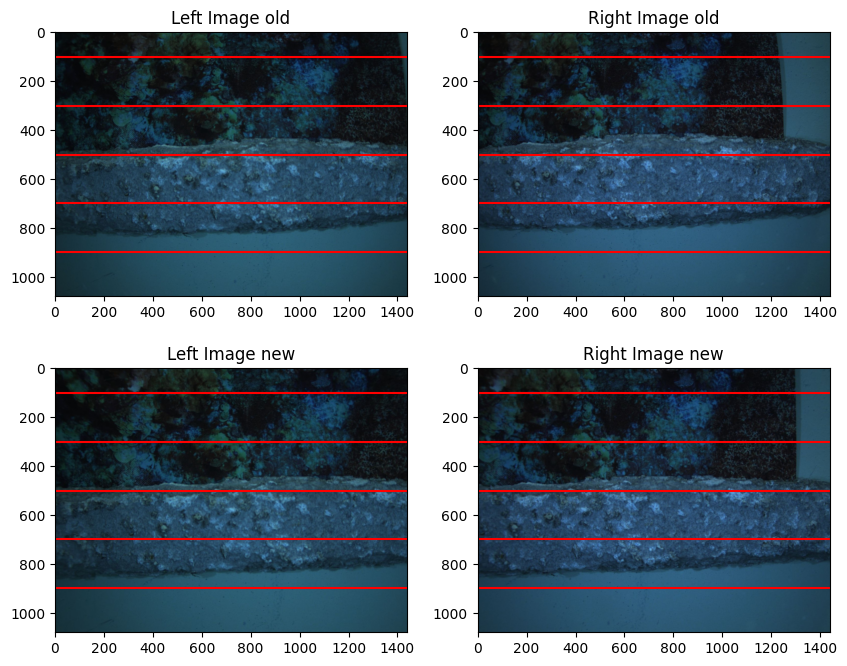

In [14]:
from enum import nonmember
# (Code) Show one undistorted pair of images (Left and Right)

# base paths
left_path = "./PM_Dataset/PM_Anode_Data/Left_Image/"
right_path = "./PM_Dataset/PM_Anode_Data/Right_Image/"

# choose timestamp to plot
print(len(left_timestamps))
idx = 70%len(left_timestamps)
left_t = left_timestamps[idx]
right_t = timestamp_dict[left_t]
print(f"left: {left_t} -> right: {right_t}")

# extract old images
left_old = cv2.imread(convert_int2path(left_t, left_path, None, "left"))
right_old = cv2.imread(convert_int2path(right_t, None, right_path, "right"))

# extract rectified new images
left_new = left_rect[idx]
right_new = right_rect[idx]

# plot 2 old images on first row
# plot 2 new images on second row
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# plot (0, 0)
axs[0, 0].imshow(cv2.cvtColor(left_old, cv2.COLOR_BGR2RGB))
# draw red horizontal lines to visualize disparity
for i in np.arange(100, 1000, 200):
  axs[0, 0].axhline(y=i, color='r', linestyle='-')
axs[0, 0].set_title('Left Image old')

# plot (0, 1)
axs[0, 1].imshow(cv2.cvtColor(right_old, cv2.COLOR_BGR2RGB))
# red lines
for i in np.arange(100, 1000, 200):
  axs[0, 1].axhline(y=i, color='r', linestyle='-')
axs[0, 1].set_title('Right Image old')

# plot (1, 0)
axs[1, 0].imshow(cv2.cvtColor(left_new, cv2.COLOR_BGR2RGB))
# red lines
for i in np.arange(100, 1000, 200):
  axs[1, 0].axhline(y=i, color='r', linestyle='-')
axs[1, 0].set_title('Left Image new')

# plot (1, 1)
axs[1, 1].imshow(cv2.cvtColor(right_new, cv2.COLOR_BGR2RGB))
# red lines
for i in np.arange(100, 1000, 200):
  axs[1, 1].axhline(y=i, color='r', linestyle='-')
axs[1, 1].set_title('Right Image new')

plt.show()


# Exercise 2 - Stereo Matching and Depth Map Estimation

In this stage, you will **explore one of two** different strategies for computing disparity between the left and right images - each offering distinct advantages in terms of accuracy, density and computational cost.

- Option A (Feature-Based Matching). It begin by detecting distinctive image features using algorithms such as SIFT or ORB. These keypoints capture visually stable patterns that can be reliably identified in both the left and right views. Once detected, match the corresponding features across the image pair to establish pixel correspondences.
With these matches, estimate the fundamental or essential matrix to describe the geometric relationship between the two cameras. Using this relationship, you can then triangulate the matched points to obtain their 3D coordinates in space.

- Option B (Dense Stereo Matching).
Alternatively, you can adopt a dense correspondence approach to compute a disparity value for every pixel in the image. This can be achieved using algorithms like SSD, SAD or OpenCV StereoBM or StereoSGBM, which leverage block matching and semi-global optimization to estimate disparities across the entire image.
Once the disparity map is computed, convert it into a depth map using the known camera baseline (distance between the two cameras) and focal length.

In [ ]:
# do implementation here

In [15]:
def get_pixel_pairs(left_img, right_img):
  # convert to grayscale
  left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
  right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)
  # sift detector
  sift = cv2.SIFT_create(  # tune if needed
        nfeatures=10000,
        contrastThreshold=0.01,
        edgeThreshold=10,
        sigma=1.6)
  # extract keypoints and descriptors using the sift detector on both images
  kptsL, descL = sift.detectAndCompute(left_gray, None)
  kptsR, descR = sift.detectAndCompute(right_gray, None)
  # find 2 nearest right descriptors for each left descriptor
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False) # brute force matcher
  matches = bf.knnMatch(descL, descR, k=2)
  print(f"detected {len(matches)} matches with sift")

  good_matches = []
  for m1, m2 in matches:
    # Lowe's condition for distinct descriptors
    if m1.distance < 0.75*m2.distance:
      good_matches.append(m1)
  print(f"detected {len(good_matches)} good matches after Lowe's condition")

  # extract pixel coordinates of good matches
  left_pixels = np.array([kptsL[m.queryIdx].pt for m in good_matches])
  right_pixels = np.array([kptsR[m.trainIdx].pt for m in good_matches])
  # detect outliers
  F, inliers = cv2.findFundamentalMat(left_pixels, right_pixels, cv2.FM_RANSAC)
  inliers = inliers.ravel().astype(bool)
  #left_pixels = left_pixels[inliers]
  #right_pixels = right_pixels[inliers]
  # remove invalid pixels
  dy = np.abs(left_pixels[:, 1] - right_pixels[:, 1])
  dx = left_pixels[:, 0] - right_pixels[:, 0]
  dy_max = 5
  dx_min = 2
  mask = (dy < dy_max) & (dx > dx_min)
  left_pixels = left_pixels[mask]
  right_pixels = right_pixels[mask]
  # get colors
  left_img_rgb = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
  colors_left = left_img_rgb[left_pixels[:, 1].astype(int), left_pixels[:, 0].astype(int)]
  print(f"detected {left_pixels.shape[0]} good matches after filtering")
  return left_pixels, right_pixels, colors_left




In [16]:
"""
pixels are lists of lists of dimension (N, 2)
return the world points (N2, 3) as a numpy array, where N2 <= N (eliminate invalid disparities)
"""

def get_3D_points(pixels_left, pixels_right, c_dict):
  # extract u (x direction) and v (y direction) pixel coordinates
  u_left = np.array([u for u, v in pixels_left])
  v_left = np.array([v for u, v in pixels_left])
  u_right = np.array([u for u, v in pixels_right])
  v_right = np.array([v for u, v in pixels_right])
  N = len(u_left)
  # compute disparity
  disp = u_left - u_right
  # compute a histogram of disparity and plot it
  plt.hist(disp, bins=100)
  plt.xlabel('Disparity')
  plt.ylabel('Frequency')
  min_disp = 1e-6
  mask = disp > min_disp # valid disparities mask
  # get calib parameters
  P1 = c_dict["P1"]
  f = P1[0, 0]
  cx = P1[0, 2]
  cy = P1[1, 2]
  P2 = c_dict["P2"]
  B = -P2[0, 3]/f
  # compute Z
  Z = f*B/disp
  # compute X and Y centered in the left frame
  X = Z * (u_left - cx) / f
  Y = Z * (v_left - cy) / f
  # concatenate
  points3D = np.column_stack([X[mask], Y[mask], Z[mask]]) # (N2, 3)
  return points3D

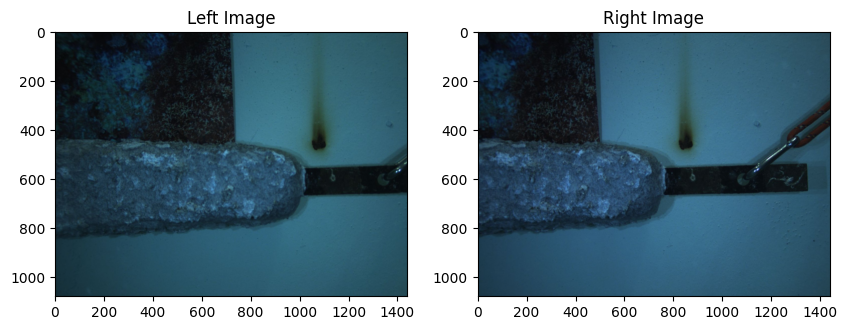

In [17]:
N = len(left_rect)
idx = 100%N

# plot the left_rect and right_rect images
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(cv2.cvtColor(left_rect[idx], cv2.COLOR_BGR2RGB))
axs[0].set_title('Left Image')
axs[1].imshow(cv2.cvtColor(right_rect[idx], cv2.COLOR_BGR2RGB))
axs[1].set_title('Right Image')
plt.show()

detected 9468 matches with sift
detected 2623 good matches after Lowe's condition
detected 2603 good matches after filtering


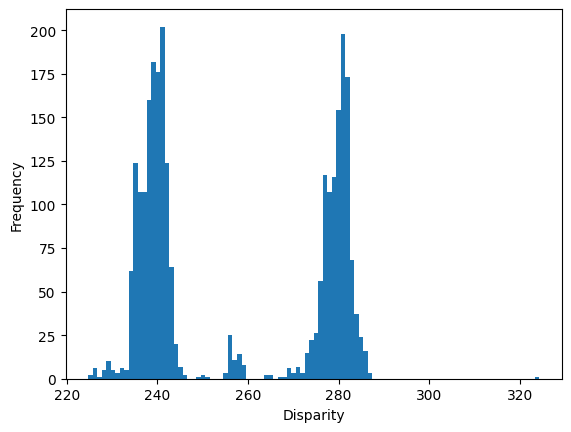

In [18]:
# get pixel pairs
left_pixels, right_pixels, colors_left = get_pixel_pairs(left_rect[idx], right_rect[idx])
# get 3D points
points3D = get_3D_points(left_pixels, right_pixels, calib_dict)
# create point cloud from 3D points
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points3D)
# associate colors to points
pcd.colors = o3d.utility.Vector3dVector(colors_left)
# visualize point cloud
axis = o3d.geometry.TriangleMesh.create_coordinate_frame(
        size=0.05,    # scale of the axis
        origin=[0,0,0]  # origin in world coordinates
)

draw_geometries([pcd, axis])

**Deliverable**:


In [ ]:
# (Code) Show corresponding epipolar lines to verify rectification.

In [ ]:
# (Code) Displaying the disparity map

In [ ]:
# (Code) Displaying the depth map

 - Discussion on the trade-offs between feature-based or dense stereo matching approaches. Justify your selection.

 <font color='red'> Justify Here (4 lines) ... </font>

# Exercise 3 - Point Cloud Generation and Preprocessing
Transform depth maps into 3D point clouds. Using the standard projection formula, each pixel in the depth map can be reprojected into 3D space, yielding a set of points that represent the visible surface of the anode. To make the model visually meaningful, assign color information from the corresponding pixels in the left image to each 3D point. This process produces a textured point cloud, allowing you to visually identify surface details and material characteristics directly in 3D.

Before further processing, it's essential to clean and refine the point clouds. Raw reconstructions often contain noise, especially in regions affected by low contrast, refraction, or poor stereo matching. Begin by removing outliers to eliminate isolated or spurious points that don't belong to the actual surface. If the resulting dataset is too large or unevenly sampled, you may downsample the point cloud to a uniform density, improving computational efficiency for subsequent registration steps. Optionally, you can also apply smoothing filters to reduce small-scale noise and improve surface continuity.


In [ ]:
# do implementation here

**Deliverable:**


In [ ]:
#  Visualization of one pre-filtered point cloud with texture (Open3D)

In [ ]:
#  Visualization of one post-filtered point clouds with texture (Open3D)

 - Discussion about the technical decisions as well as, the outcome related to noise, density and visual appearance.

 <font color='red'> Justify Here (3 lines) ... </font>

# Exercise 4 — 3D Registration of Two Consecutive Point Clouds

Begin the reconstruction process by focusing on the alignment of **two consecutive point clouds**. Each cloud represents a partial view of the anode captured from slightly different camera positions as the stereo rig moves laterally. To create a 3D model, these views must be accurately registered in a common coordinate system. Start with an initial alignment. This rough alignment serves as the starting point for a more precise adjustment. Next, refine the registration using an Iterative Closest Point (ICP) -based algorithm. ICP iteratively minimizes the distance between overlapping regions of the two point clouds, improving their relative alignment until convergence. The result should be a well-registered pair of clouds that fit together smoothly, forming a coherent section of the anode's surface.

In [ ]:
# do implementation here

**Deliverable:**

In [ ]:
# Visualization of the aligned model (Open3D)

In [ ]:
# Report ICP convergence metrics (residuals, iterations).

 - Describe the reasons for selecting a specific 3D Registration technique for this problem (error, density and visual appearance).

 <font color='red'> Justify Here (4 lines) ... </font>

# Exercise 5 — Multi-view 3D Registration

Extend your registration process to the entire dataset. Instead of aligning only two consecutive point clouds, sequentially register all valid point clouds acquired along the scanning path. Each new alignment should build upon the previous ones, gradually assembling a complete representation of the anode.
Once all point clouds have been successfully registered into a single coordinate frame, merge them to create the full 3D model. Incorporate the color information from the left images to produce a textured reconstruction, capturing both the geometry and visual appearance of the anode.

The outcome of this step should be a cohesive, high-quality 3D model that accurately reflects the anode's surface structure and material characteristics across its entire length.

In [ ]:
# do implementation here

**Deliverable:**

In [ ]:
# Visualization of the model of the anode (Open3D)

In [ ]:
# Save of the anode model to a file (Open3D).
# ATTENTION::: Download the file to your computer since it will be needed during the submission of the assignment.

# Exercise 6 — Physical Measurements of the Anode

With the complete 3D reconstruction of the anode now available, the next step is to extract key physical measurements from the model. These quantitative assessments will help evaluate both the geometry of the anode and the accuracy of your reconstruction.

Compute the following parameters:

- Maximum width along the X-axis — representing the total horizontal span of the anode.

- Maximum height along the Y-axis — corresponding to its vertical extent.

- Total volume.

- Width of the supporting metal brackets located at each end of the anode.

Finally, visualize these measurements directly on the 3D model using annotated plots or overlays.

In [ ]:
# do implementation here

**Deliverable:**

A short table with all measured quantities.

<font color='red'> Add table here ... </font>

Justify of how measurements were obtained (the implementation that was performed to automatically extract the values).

 <font color='red'> Justify Here (4 lines) ... </font>

--------------------------------------------------------------------------

# Ethics

<font color='red'>
Disclaimer for the use of AI tools: complete the text that is placed in between brackets. Convert this disclaimer to PDF, sign it and deliver the PDF in Moodle.
</font>


<font color='red'> [Student Name #1] </font> and <font color='red'> [Student Name #2] </font> declare that the work presented in this assignment titled "[Assignment Title]" was completed independently, except where explicitly noted. I confirm the following with regard to the use of AI tools:

**Extent of AI Tool Contribution:**

I have used the following AI tool(s) for assistance in this assignment:

1. Tool(s) Used: [List AI tools used, e.g., ChatGPT, Grammarly, QuillBot, etc.]
Nature of Assistance: [Specify the task(s) for which the AI tool was used, e.g., brainstorming ideas, refining language, generating summaries, grammar correction, etc.]
2. Percentage of AI Contribution: [Estimate the percentage of the assignment influenced by the AI tool.]
3. Human Oversight and Contribution:
Despite the use of AI tools, I confirm that the critical thinking, analysis, problem-solving, and final decision-making processes in this assignment were carried out by me. The AI tools were used solely as support for the following purposes: [Elaborate on how the AI tool helped, e.g., improving readability, offering suggestions for structure, or enhancing clarity.]


**Originality and Integrity:**
I take full responsibility for ensuring that the content of this assignment is original and properly cited where applicable. The use of AI tools did not result in any unintentional plagiarism or misrepresentation of ideas from external sources.

**Compliance with Academic Integrity Guidelines:**
I understand the importance of academic integrity, and I confirm that the usage of AI tools complies with the guidelines provided by [School/University Name]. All AI-generated outputs were critically evaluated and appropriately incorporated into the final submission.

Signed,
[Student Name]
[Date]